# Assignment 3- Scatterplot, dimension reduction and clustering

You are strongly encouraged to work on this assignment with one or two partners. Please ensure only one submission per group: upload the PDF report to Gradescope and the code (or Jupyter notebook) to D2L. The dataset CSV file for Assignment 3 can be found on D2L.

This dataset is based on real-world data, not synthetic, so don't anticipate very clear-cut clusters or trends. There's no single correct answer to any question. Aim to thoroughly explain your analysis and the reasoning behind your choices as effectively as possible.

In [109]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score



In this assignement, we focus on ```heart failure clinical records dataset```,from [UCI Machine Learning repository](https://archive-beta.ics.uci.edu/). It includes the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features  and you can access more information about this dataset [here](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)


In [110]:
heart=pd.read_csv('heart_failure_clinical_records_dataset.csv')
# excludes binary vars
numerical = heart.drop(columns=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT'])
# excludes numerical vars
categorical = heart.drop(columns=['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time'])

# Problem 1- Scatterplots (50 points) 

### (a) 10 points- (EP)
Get to know the dataset by generating summary statistics for the numerical variables, such as mean, median, and standard deviation. Address any missing values and outliers. Which variables do you think might be crucial in determining patient survival? Which variables seem to be most closely correlated.

[Summary Statistics Pandas Resource](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html)

In [111]:
# mean, median, standard deviation
print("Mean Values for Numerical Data:\n" + str(numerical.mean()) + "\n")
print("Median Values for Numerical Data:\n" + str(numerical.median()) + "\n")
print("Standard Deviations for Numerical Data:\n" + str(numerical.std()) + "\n")

Mean Values for Numerical Data:
age                             60.833893
creatinine_phosphokinase       581.839465
ejection_fraction               38.083612
platelets                   263358.029264
serum_creatinine                 1.393880
serum_sodium                   136.625418
time                           130.260870
dtype: float64

Median Values for Numerical Data:
age                             60.0
creatinine_phosphokinase       250.0
ejection_fraction               38.0
platelets                   262000.0
serum_creatinine                 1.1
serum_sodium                   137.0
time                           115.0
dtype: float64

Standard Deviations for Numerical Data:
age                            11.894809
creatinine_phosphokinase      970.287881
ejection_fraction              11.834841
platelets                   97804.236869
serum_creatinine                1.034510
serum_sodium                    4.412477
time                           77.614208
dtype: float64



In [112]:
# missing values
numerical.isna().sum()

age                         0
creatinine_phosphokinase    0
ejection_fraction           0
platelets                   0
serum_creatinine            0
serum_sodium                0
time                        0
dtype: int64

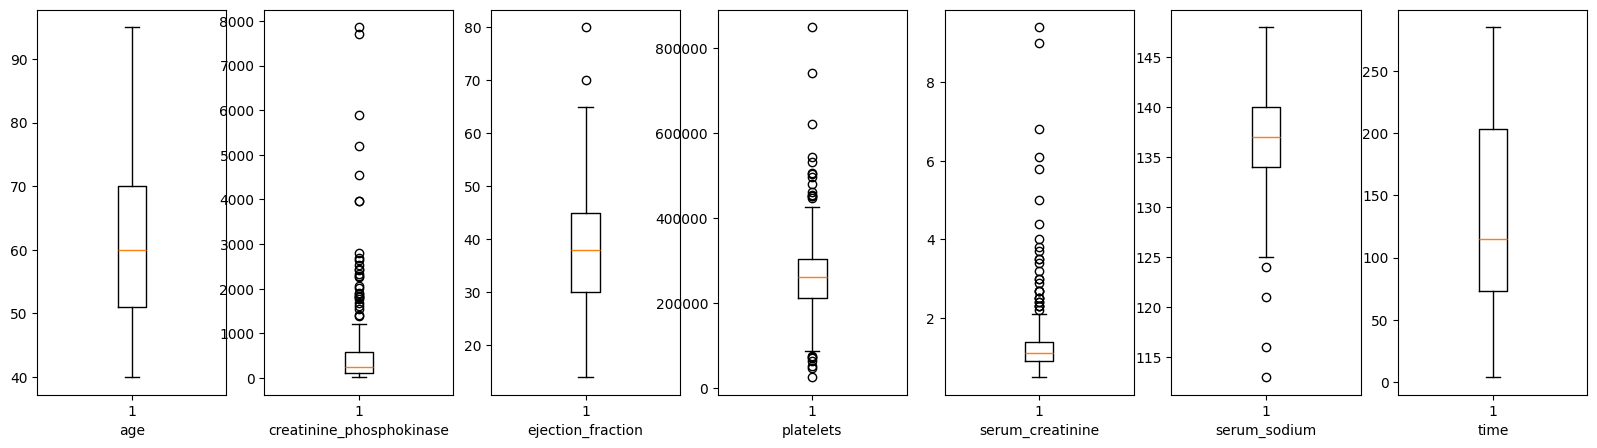

In [113]:
# outliers code
fig, ax = plt.subplots(1,len(numerical.columns), figsize=(20,5))
columnTitles = numerical.columns.tolist()

# boxplots to determine which variables 
for i in range(len(numerical.columns)):
    ax[i].boxplot(numerical.iloc[:,i])
    ax[i].set_xlabel(columnTitles[i])

In [114]:
# variables most correlated
numerical.corr().style.background_gradient(cmap='PRGn', axis=None)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
age,1.000000,-0.081584,0.060098,-0.052354,0.159187,-0.045966,-0.224068
creatinine_phosphokinase,-0.081584,1.000000,-0.044080,0.024463,-0.016408,0.059550,-0.009346
ejection_fraction,0.060098,-0.044080,1.000000,0.072177,-0.011302,0.175902,0.041729
platelets,-0.052354,0.024463,0.072177,1.000000,-0.041198,0.062125,0.010514
serum_creatinine,0.159187,-0.016408,-0.011302,-0.041198,1.000000,-0.189095,-0.149315
serum_sodium,-0.045966,0.059550,0.175902,0.062125,-0.189095,1.000000,0.087640
time,-0.224068,-0.009346,0.041729,0.010514,-0.149315,0.087640,1.000000


- Missing values: No missing values
- Outliers: There are a number of outliers present for the creatinine phosphokinase, ejection fraction, platelets, serum creatinine, and serum sodium features, based on the boxplots generated.
- Crucial Survival Variables: Some of the variables most crucial to determining patient survival might include age, ejection fraction, whether the patient has hypertension or diabetes, as well as whether a patient smokes or not.
- Variables most correlated: Based on the correlation matrix generated above, it appears the variables that have the strongest correlation would be time and age, serum_sodium and serum_creatinine, and time and serum_creatinine.

### (b) 20 points (BH)
Create pair plot and correlation matrix among the different numerical variables. Comment on your findings.

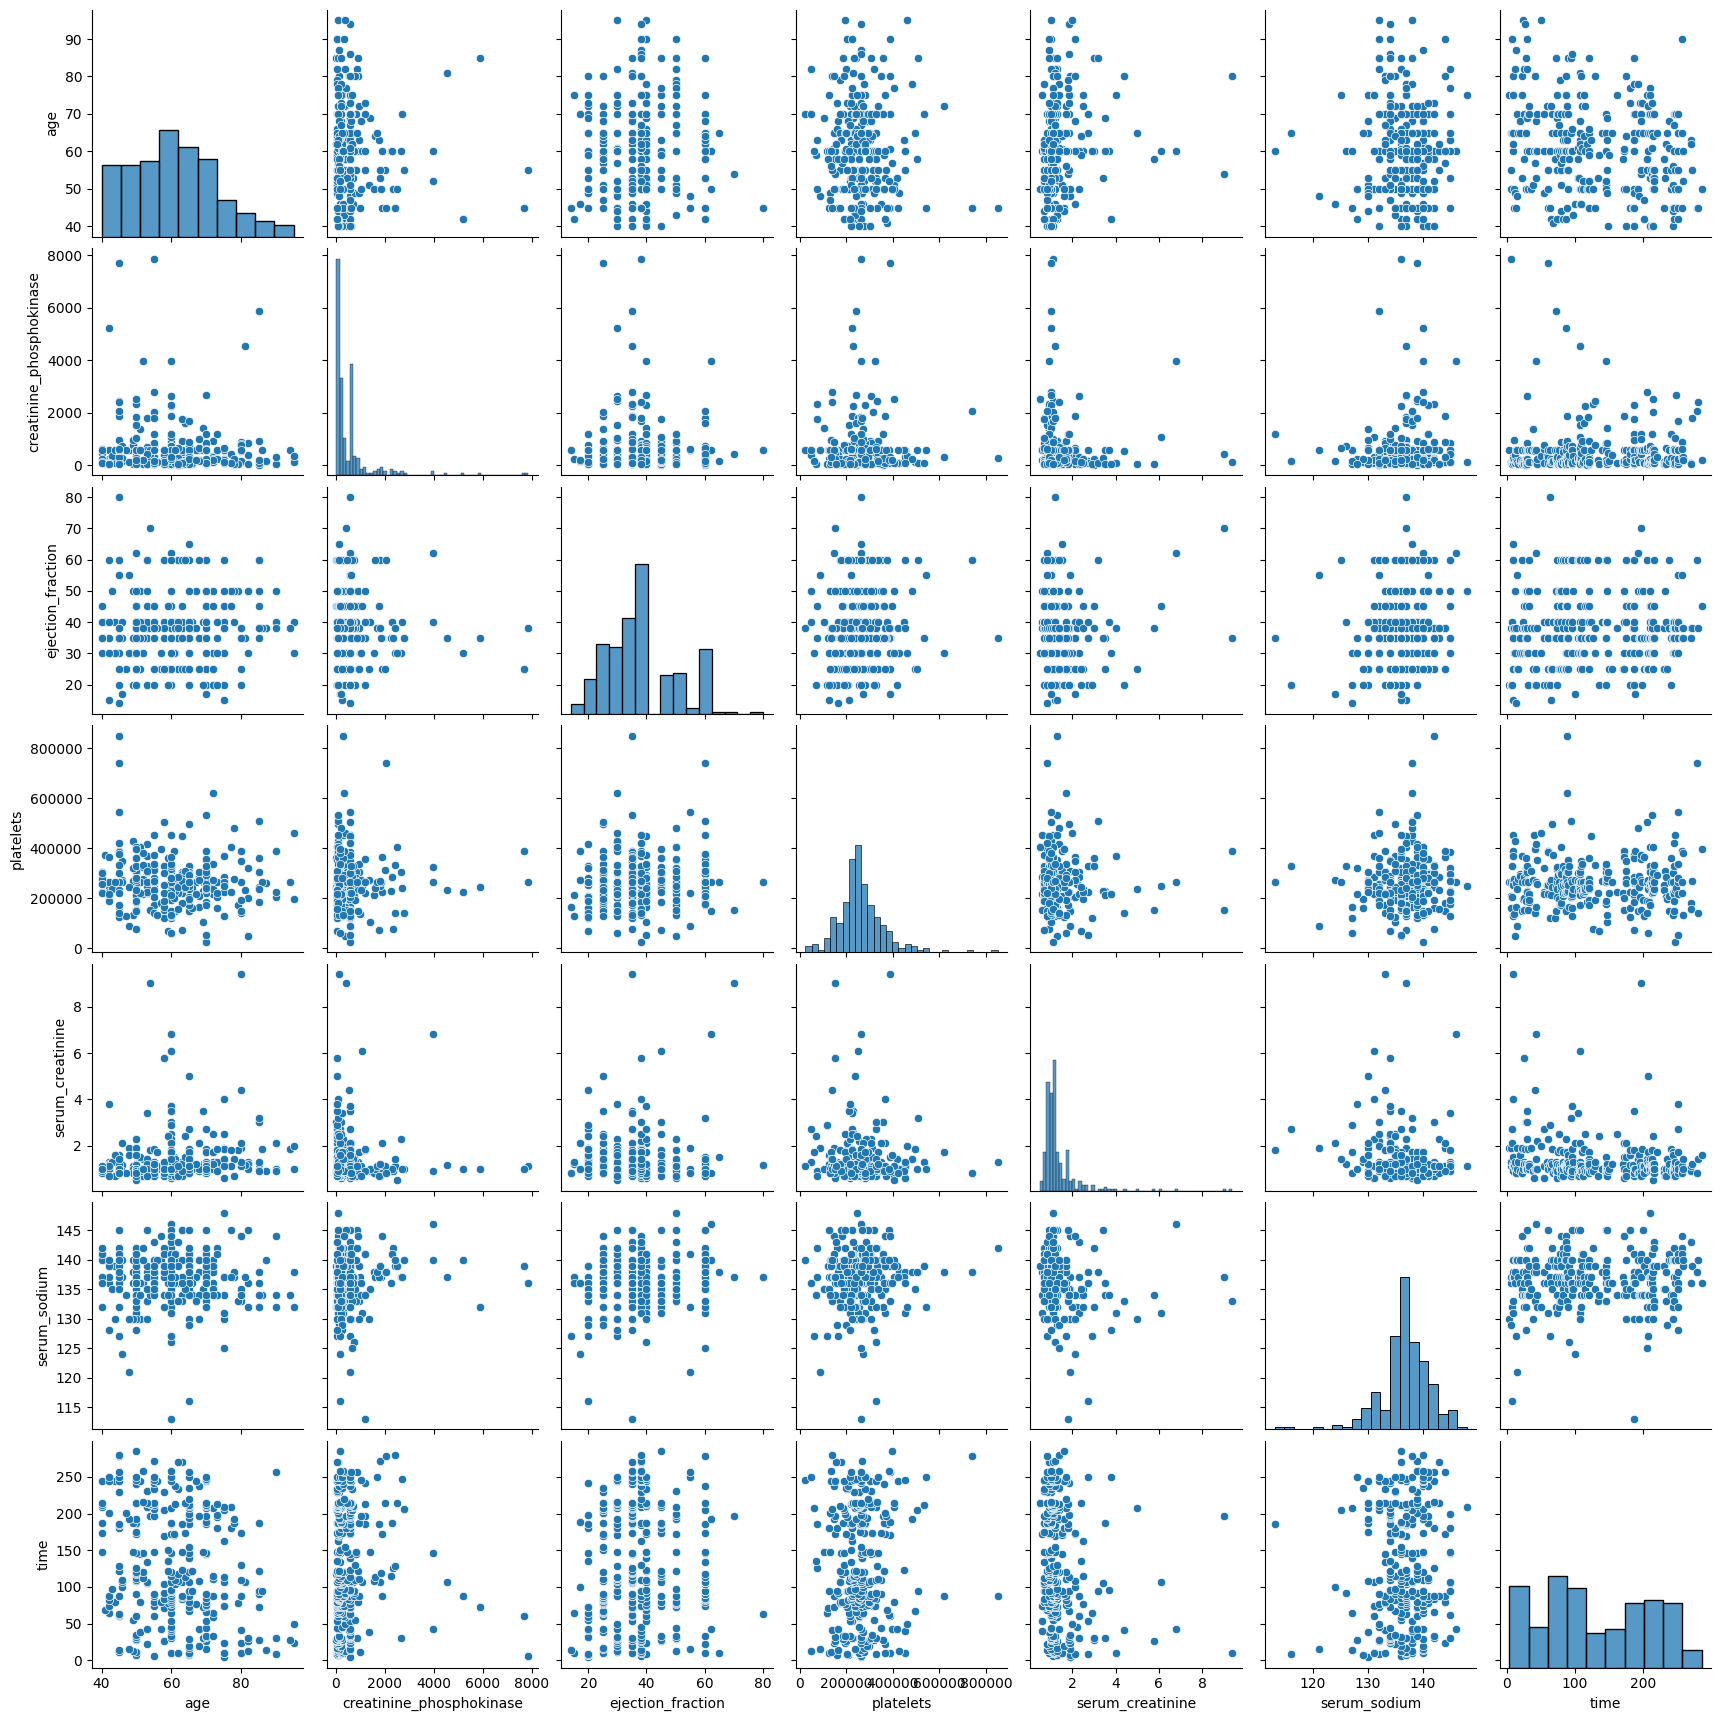

In [115]:
#pair plot
sns.pairplot(numerical)

__Pair Plot Findings:__
 - Ages 40-100 appear to to evenly spread across each numerical category
 - Low serum_creatinine is correlated with medium-to-high serum sodiums
 - Low serum creatinine seems strongly correlated with much lower creatinine phosphokinase
 - Most ages have less than 1000 KCP mcg/L (creatinine phosphokinase)

In [116]:
# Correlation Matrix
correlationMatrix = numerical.corr()
correlationMatrix

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
age,1.000000,-0.081584,0.060098,-0.052354,0.159187,-0.045966,-0.224068
creatinine_phosphokinase,-0.081584,1.000000,-0.044080,0.024463,-0.016408,0.059550,-0.009346
ejection_fraction,0.060098,-0.044080,1.000000,0.072177,-0.011302,0.175902,0.041729
platelets,-0.052354,0.024463,0.072177,1.000000,-0.041198,0.062125,0.010514
serum_creatinine,0.159187,-0.016408,-0.011302,-0.041198,1.000000,-0.189095,-0.149315
serum_sodium,-0.045966,0.059550,0.175902,0.062125,-0.189095,1.000000,0.087640
time,-0.224068,-0.009346,0.041729,0.010514,-0.149315,0.087640,1.000000


__Correlation Matrix Findings:__
- The range of corrleation is [-.224, .176] which mostly hovers around 0. This means most categories have little correlation.
- The highest positive correlation is between ejectional fraction and serum sodium.
- The highest negative correlation is between age and time.

### (c) 20 points (EP)
Explore different pairs of variables. Create two separate scatterplots and color points based on Death variable, `DEATH_EVENT` or other categorical variables. Do you see any distinctive groups.

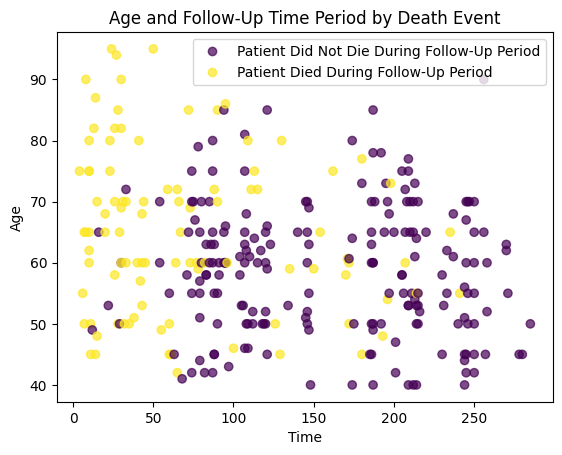

In [117]:
# scatterplot no. 1
legendLabels = ['Patient Did Not Die During Follow-Up Period', 'Patient Died During Follow-Up Period']

scatter = plt.scatter(heart['time'], heart['age'], c=heart['DEATH_EVENT'], alpha=.7)
plt.xlabel('Time')
plt.ylabel('Age')
plt.title('Age and Follow-Up Time Period by Death Event')
plt.legend(handles=scatter.legend_elements()[0], labels=legendLabels, loc='best')
plt.show()

In the above visual, the groups are not extremely distinctive; however, it does appear that the subset of data where patients died during the follow-up period tends to be shifted more to the left side of the graph than the set of data where patients did not die during the follow-up period. This potentially suggests that there might be a correlation between patients who had a shorter follow-up time period and their chances of dying during that period.

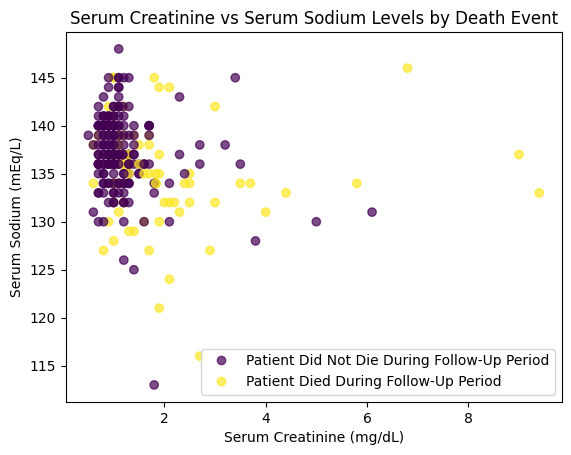

In [118]:
# scatterplot no. 2
legendLabels = ['Patient Did Not Die During Follow-Up Period', 'Patient Died During Follow-Up Period']

scatter = plt.scatter(heart['serum_creatinine'], heart['serum_sodium'], c=heart['DEATH_EVENT'], alpha=.7)
plt.xlabel('Serum Creatinine (mg/dL)')
plt.ylabel('Serum Sodium (mEq/L)')
plt.title('Serum Creatinine vs Serum Sodium Levels by Death Event')
plt.legend(handles=scatter.legend_elements()[0], labels=legendLabels, loc='best')
plt.show()

There do not appear to be very distinctive groups when analyzing serum creatinine versus serum sodium levels, colored by death event. The group of patients that died during the follow-up period does appear to have a slightly wider range of values when it comes to serum creatinine (greater number of high values) than the group of patients that did not die during the follow-up period.

# Problem 2- Dimension Reduction (50 points) 

### (a) 15 points (BH)
Perform PCA on the **standardized numerical variables**. Plot cumulative explained variance. 
How many principal components are needed to capture 80% of the variance? Comment on your results.


cumulative sum:
[0.21065323 0.37859486 0.52566331 0.66369556 0.79051471 0.89586366
 1.        ]


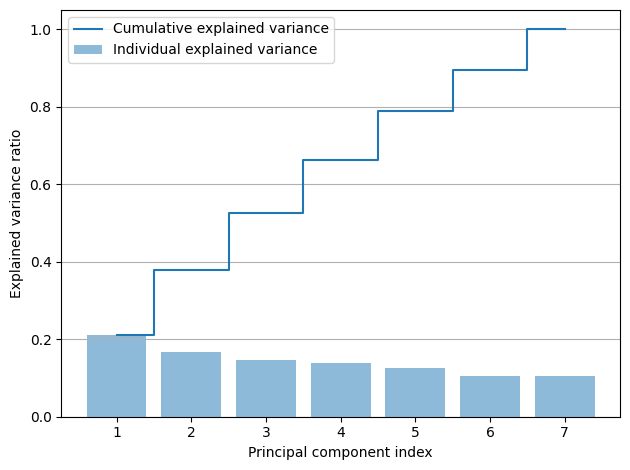

In [119]:
columnTitles = ['age', 'creatine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']

#Standardize numerical set
scaler = StandardScaler()
numericalRescale = scaler.fit_transform(numerical)
numericalRescale = pd.DataFrame(numericalRescale)
numericalRescale.columns = columnTitles


#PCA on standardized Numerial Set (uses 7 components to see which ones are most useful)
numericalPCA = PCA(n_components=7)
pcaTransformedDataset = numericalPCA.fit_transform(numericalRescale) #gives me access to .components_ and explained_variance_ratio_

#Prints PCA data
# for num, pca in enumerate(numericalPCA.components_, 1):
#     s = ''
#     for index, title in enumerate(columnTitles):
#         s += f"{title}: { str(round(pca[index], 4))} | "
#     print(f"PCA{num}: \n{s}")


#cumulative explained variance
ratioSum = numericalPCA.explained_variance_ratio_.cumsum()
print('\ncumulative sum:')
print(ratioSum)

plt.bar(range(1,len(ratioSum)+1), numericalPCA.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(ratioSum)+1), ratioSum, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.ylim (0,1.05)
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In order to get at 80% data capture, we would need at least six principle components. Five was slightly short by sitting at at value of 79.05% coverage.

### (b) 20 points (EP)
Construct a biplot that displays the data points and the loadings of each original feature in the PC1-PC2 space. Label the loading vectors (arrows). Share your observations. Discuss which type of patient is best represented in each quadrant of the plot.

Text(0.5, 1.0, 'Loadings of Original Features on PC1 and PC2')

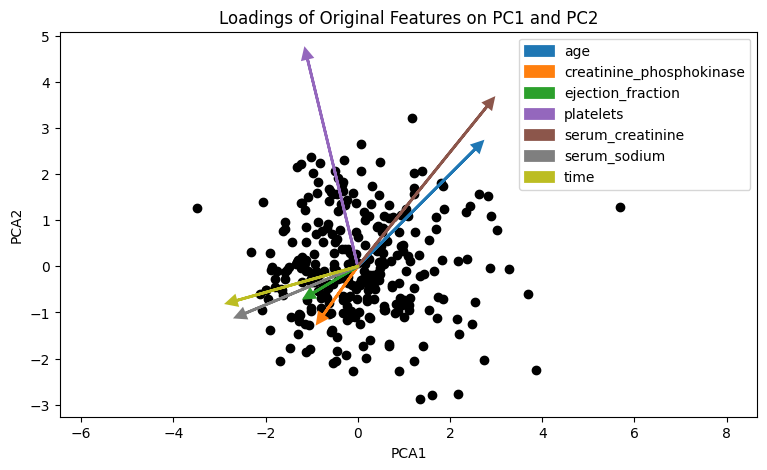

In [120]:
numericalTransformed = numericalPCA.fit_transform(numericalRescale)
loadings = numericalPCA.components_

# alter plot size so that legend will not overlap with datapoints
plt.figure(figsize=(9, 5))
plt.scatter(numericalTransformed[:,0], numericalTransformed[:,1], color='k')

# scaling factor will be used to lengthen loading arrows, making them more visible
scalingFactor = 5.5

columnTitles = numerical.columns.tolist()

for i in range(loadings.shape[1]):
    # plt.cm.tab10() allows arrows to be color-coded, each with a distinct color
    arrowColor = plt.cm.tab10(i / loadings.shape[1])
    plt.arrow(0, 0, scalingFactor*loadings[0, i], scalingFactor*loadings[i, i],  color=arrowColor, linewidth=2, head_width=.2, head_length=.2, label=columnTitles[i])
    
plt.axis('equal');
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# create legend
plt.legend(loc='upper right')

plt.title("Loadings of Original Features on PC1 and PC2")


*Overall, it seems that much of the data on this plot is well explained by the combination of loadings, except for data points that have more negative PC2 values but more positive PC1 values. The loadings are not as spread out as one might hope, as there are several arrows that point in locations fairly close in proximity.*

*In the first quadrant of the plot, it appears that patients with high levels of platelets will be best represented. In the second quadrant, patients who are older in age and have higher levels of serum creatinine will be best represented. There are not many loadings pointing in the direction of the third quadrant, but any patient with lower levels of serum sodium or creatinine phosphokinase, lower ejection fraction rates, or shorter follow-up time periods will be best represented in the fourth quadrant.*

### (c) 15 points (BH)
Color-code the data points based on DEATH_EVENT or other categorical variables within the dataset. Evaluate whether dimension reduction has facilitated a clearer distinction between the various patient groups.

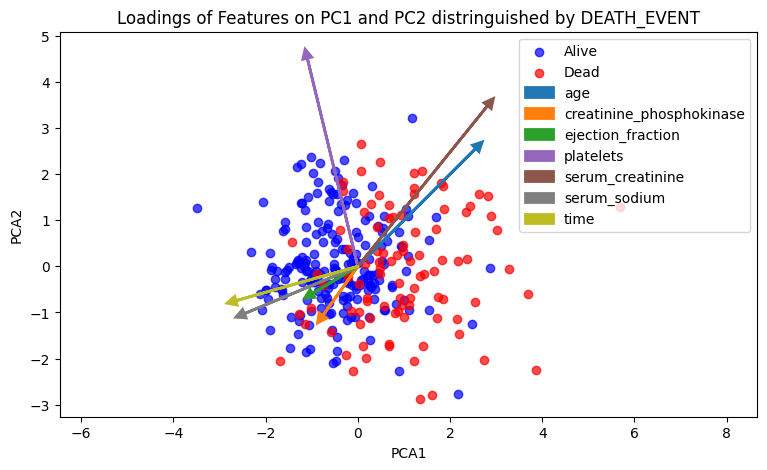

In [121]:
numericalTransformed = numericalPCA.fit_transform(numericalRescale)
loadings = numericalPCA.components_

# Alter plot size so that legend will not overlap with datapoints
plt.figure(figsize=(9, 5))

# Scatter plot with colors based on 'DEATH_EVENT'
scatter_alive = plt.scatter(numericalTransformed[heart['DEATH_EVENT'] == 0, 0], numericalTransformed[heart['DEATH_EVENT'] == 0, 1], c='b', label='Alive',alpha = .7)
scatter_dead = plt.scatter(numericalTransformed[heart['DEATH_EVENT'] == 1, 0], numericalTransformed[heart['DEATH_EVENT'] == 1, 1], c='r', label='Dead',alpha = .7)

scalingFactor = 5.5

columnTitles = numerical.columns.tolist()

# Plot arrows and collect handles and labels
arrow_handles = []
arrow_labels = []
for i in range(loadings.shape[1]):
    arrowColor = plt.cm.tab10(i / loadings.shape[1])
    arrow = plt.arrow(0, 0, scalingFactor*loadings[0, i], scalingFactor*loadings[i, i],  color=arrowColor, linewidth=2, head_width=.2, head_length=.2, label=columnTitles[i])
    arrow_handles.append(arrow)
    arrow_labels.append(columnTitles[i])
    
plt.axis('equal')
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Combine legends
plt.legend(handles=[scatter_alive, scatter_dead] + arrow_handles, 
           labels=['Alive', 'Dead'] + arrow_labels, 
           loc='upper right', 
            )

plt.title("Loadings of Features on PC1 and PC2 distringuished by DEATH_EVENT")
plt.show()

Dimension reduction has made patient groups a more distinguishable from before. It's interesting that there are more patient deaths on the higher end of PC 1 compare to PC 2, where deaths seem almost evenly spread across PC 2

# Problem 3- Clustering (100 points) 

### (a) 15 points (BH)
Apply K-means clustering to the PCA-transformed data (referencing the number of PCA components selected in 2a). Experiment with a variety of K values and graph the resulting Inertias and Average Silhouette Coefficients for each K. Analyze the graphs to determine the optimal number of clusters. Which cluster count do you prefer when considering both metrics?

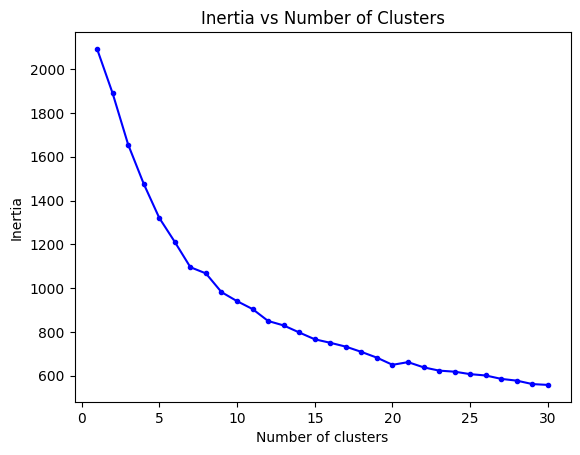

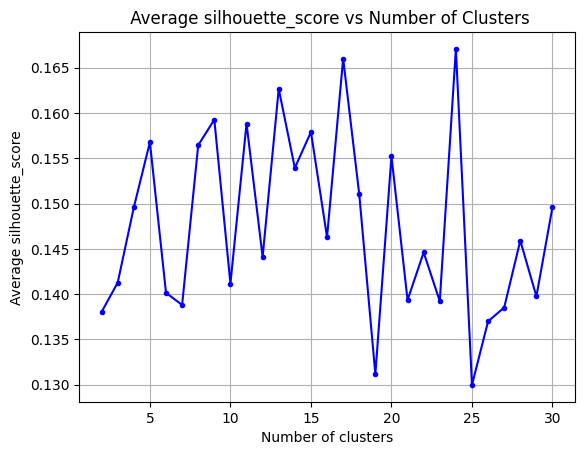

In [122]:
#==============================================================================================
#                           KMeans Clustering
#==============================================================================================

# 'pcaTransformedDataset' is the pca-transformed numpy array
n_loops = 30 # consistent int to have the inertia and silhouette graph loop the same amount
inertias = np.zeros(n_loops)
#retrieves interias and fills them in empty array
for i in range(1, n_loops+1):
    kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, random_state=0)
    kmeans.fit_predict(pcaTransformedDataset)
    inertias[i-1] = kmeans.inertia_
#plots inertia
plt.plot(range(1,n_loops+1), inertias, c='b', marker='.')
plt.title("Inertia vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

#==============================================================================================
#                     Average Silhouette scores
#==============================================================================================

S_scores = []
for n_clusters in range(2, n_loops+1):
    km = KMeans(n_clusters=n_clusters)
    
    # Predict the cluster for each data point
    preds = km.fit_predict(pcaTransformedDataset)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(pcaTransformedDataset, preds, metric='euclidean')
    S_scores.append(score)

plt.plot(range(2,n_loops+1), S_scores, c='b', marker='.')
plt.title(" Average silhouette_score vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette_score")
plt.grid("y-axis")
plt.show()


When considering the inertia graph and the average silhouette graph, the optimal number of clusters appears to be from 8-12. 10 is at the lower end of the interia 'elbow' as well as being the peak average silhouette score when testing 30 cluster sizes. Since this is most likely a local minimum, the graph shifts each time the program is run. After running it a handful of times, 10 has peaked the most on the average silhouette score.

### (b) 20 points (BH)
Interpret the characteristics of typical patients in each cluster for the chosen K value from the previous question. This involves reversing the PCA and standard scaler transformations applied to the centroid vectors. Share your insights on the findings. Are there any notable differences between the clusters?

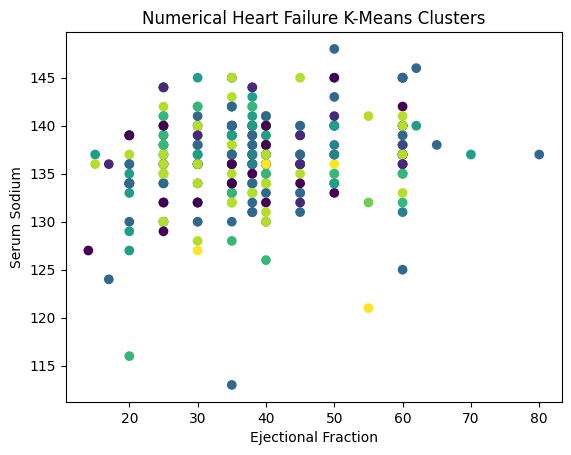

In [123]:
# reverses pca
originalNumData = numericalPCA.inverse_transform(pcaTransformedDataset)
# reverses Standard Scaler
originalNumData = scaler.inverse_transform(originalNumData)

#
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300) #kmeans requires knowing the number of clusters. In this case we wouldnt know there are 4 so we assume 3
pred_cluster_labels = kmeans.fit_predict(originalNumData) #array that tells you which point exists in which cluster

plt.scatter(originalNumData[:,2],originalNumData[:,5], c=pred_cluster_labels)
#plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=50)
plt.xlabel("Ejectional Fraction")
plt.ylabel("Serum Sodium")
plt.title("Numerical Heart Failure K-Means Clusters")
plt.show()


Most of the clusters do not appear to have any correlation.The graph above is a visualization of the variables that had the most correlation: ejectional fraction and serum sodium. Even with this graph, each cluster appears to be randomly dispersed.

### (c) 20 points (BH)
Using only the first two principal components (PCs), generate two scatterplot subplots. In the first subplot, color-code the data points according to the predicted cluster assignments. In the second subplot, use color-coding to represent 'death' or other categorical variables. Examine both plots and share any significant findings or patterns that become apparent from this comparative analysis.

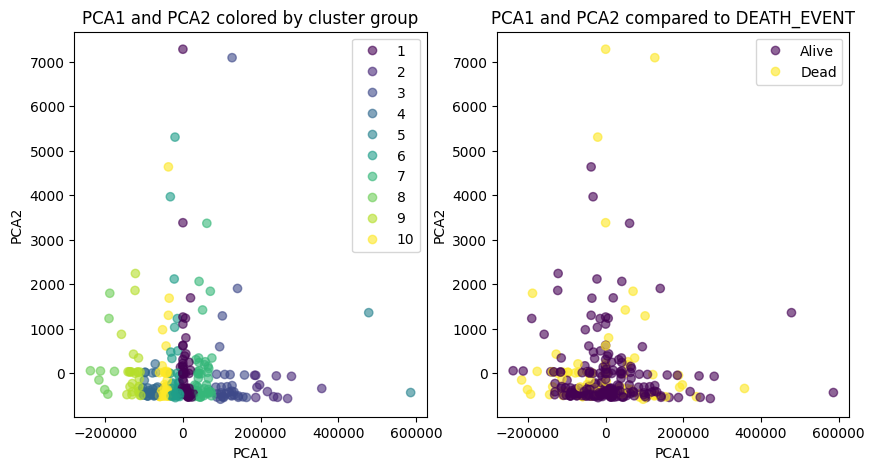

In [124]:
numericalPCA = PCA(n_components=2) # two Principle Components
numerical_transformed = numericalPCA.fit_transform(numerical)
kmeans = KMeans(n_clusters=10, init='k-means++') #kmeans requires knowing the number of clusters. In this case we wouldnt know there are 4 so we assume 3
pred_cluster_labels = kmeans.fit_predict(originalNumData)

fig, axes = plt.subplots(1,2, figsize =(10,5) )
#left plot
s1 = axes[0].scatter(numerical_transformed[:,0], numerical_transformed[:,1], c=pred_cluster_labels, alpha=.6)
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("PCA2")
axes[0].set_title("PCA1 and PCA2 colored by cluster group")

#right plot
s2 = axes[1].scatter(numerical_transformed[:,0], numerical_transformed[:,1], c=heart['DEATH_EVENT'], alpha=.6)
axes[1].set_xlabel("PCA1")
axes[1].set_ylabel("PCA2")
axes[1].set_title("PCA1 and PCA2 compared to DEATH_EVENT")

#legends
deathLabel = ['Alive', 'Dead']
clusterLabel = [i for i in range(1,13)]
axes[0].legend(handles=s1.legend_elements()[0], labels=clusterLabel, loc='upper right')
axes[1].legend(handles=s2.legend_elements()[0], labels=deathLabel, loc='upper right')



In problem 3b, we were generating clusters against the original numerical datapoints. When we graphed those, cluster points appeared to bea randomly spread out for eaceh graph. Howver, once you graph the PCAs as a whole, there is a clear distinction between each cluster. By only analyzing correlation between individual variables, we would never be able to identify these groups. The death_event graph is more spread out than I expected. There are more living outliers when looking towards the high-end of the first principle component. The inverse is true for the second principle component, the outliers are deceased toward the higher end. In terms of the average, death is consistent between all varialbes since the the majority of the PCA data is centered around the intersection between zero PCA 1 and zero PCA 2.

### (d) 15 points (EP)

Construct dendrograms for various linkage methods (complete, single, ward). Assess which linkage method appears most suitable. Determine the most appropriate number of clusters based on the dendrograms.

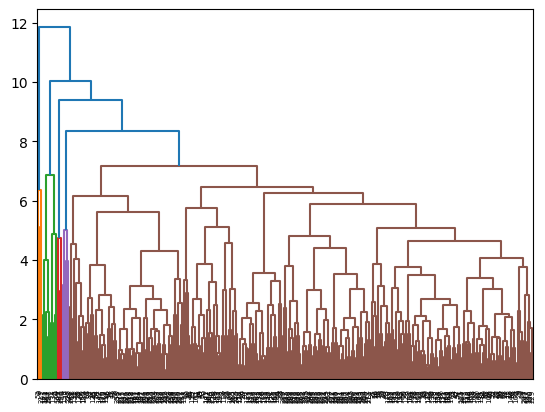

In [125]:
# dendrogram with complete linkage method
compDendrogram = sch.dendrogram(sch.linkage(pcaTransformedDataset, method='complete'))

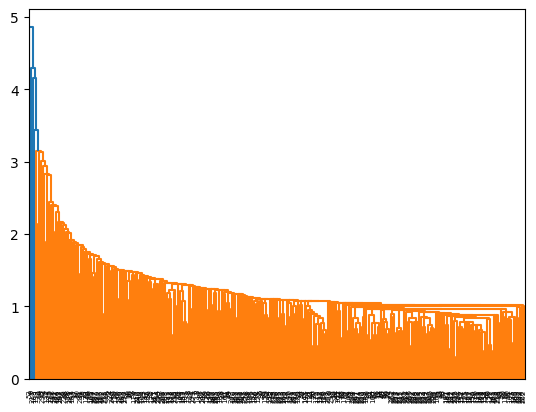

In [126]:
# dendrogram with single linkage method
singleDendrogram = sch.dendrogram(sch.linkage(pcaTransformedDataset, method='single'))

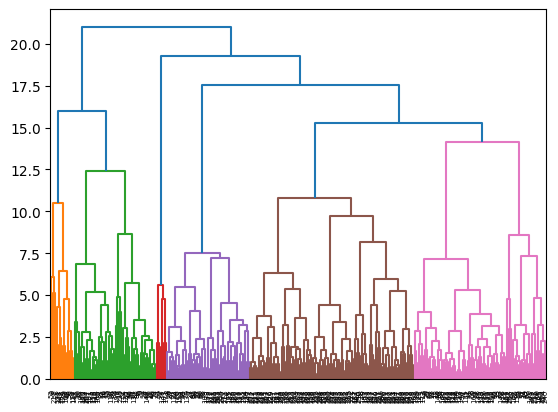

In [127]:
# dendrogram with ward linkage method
wardDendrogram = sch.dendrogram(sch.linkage(pcaTransformedDataset, method='ward'))

*Based on the three dendrograms generated above, it appears that the dendrogram using Ward's linkage is probably most suitable. Based on this dendrogram specifically, we estimate that the appropriate number of clusters is around 6.*

### (e) 15 points (EP)
Redo part a of problem 3, but use hierarchical clustering (AgglomerativeClustering) in place of k-means. Use the the linkage type you chose in previous question. Test different numbers of clusters and plot the resulting Inertias and Average Silhouette Coefficients for each cluster count. Examine these plots to identify the ideal number of clusters. Based on both metrics, which number of clusters seems most appropriate? Compare the results with those obtained from part a; did the choice of clustering method lead to a different outcome? 

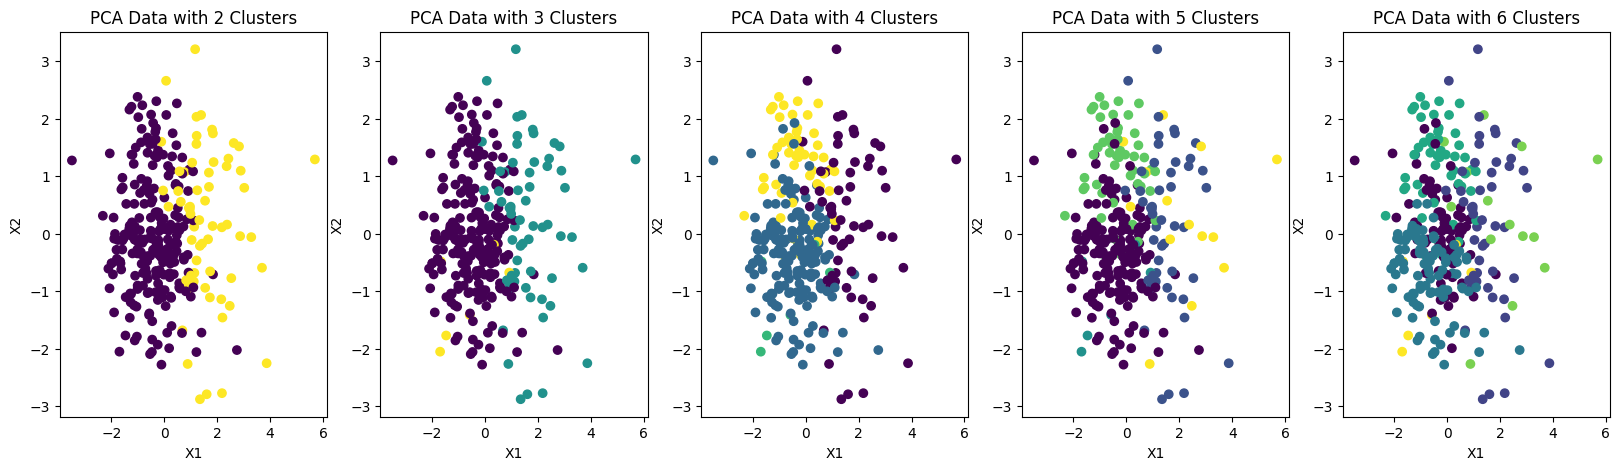

In [128]:
fig, ax = plt.subplots(1,5, figsize=(20,5))

# create a scatterplot for each number of clusters
for n_clusters in range(2,7):
    # create hierarchical model with given number of clusters (ranging from 2-6 clusters)
    AggModel = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    AggModel.fit_predict(pcaTransformedDataset)
    labels = AggModel.labels_
    
    ax[n_clusters-2].scatter(pcaTransformedDataset[:,0],pcaTransformedDataset[:,1], c=labels)
    ax[n_clusters-2].set_xlabel('X1')
    ax[n_clusters-2].set_ylabel('X2')
    ax[n_clusters-2].set_title('PCA Data with ' + str(n_clusters) + ' Clusters')

In [129]:
# calculate silhouette coefficients
S_scores = []

for n_clusters in range(2, 7):
    model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    model.fit_predict(pcaTransformedDataset)
    # Predict the cluster for each data point
    preds  = model.labels_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(pcaTransformedDataset, preds, metric='euclidean')
    #print('For n_clusters = {}, the average silhouette_score is : {}'
    #      .format(n_clusters, score.round(5)))
    S_scores.append(score)


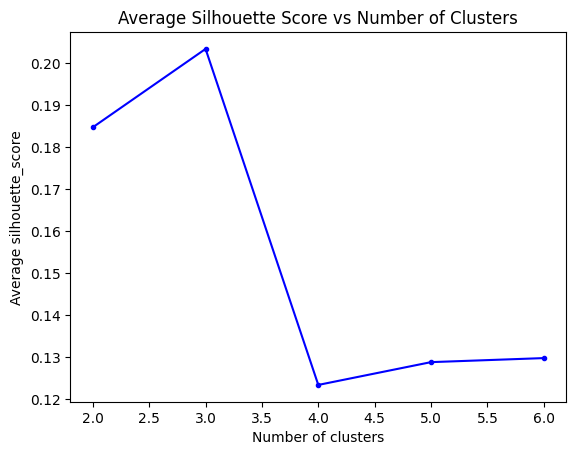

In [130]:
# plot silhouette coefficients for each number of clusters
plt.plot(range(2,7), S_scores, c='b', marker='.')
plt.title("Average Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette_score");

*Based on the calculated silhouette coefficients, the ideal number of clusters is 3. This result is different than that obtained in part a, which estimated 10 clusters; clearly, the choice of clustering method leads to different outcomes when it comes to this dataset.*

### (f) 15 points (EP)
Redo part c and compare the results. Any significant difference?

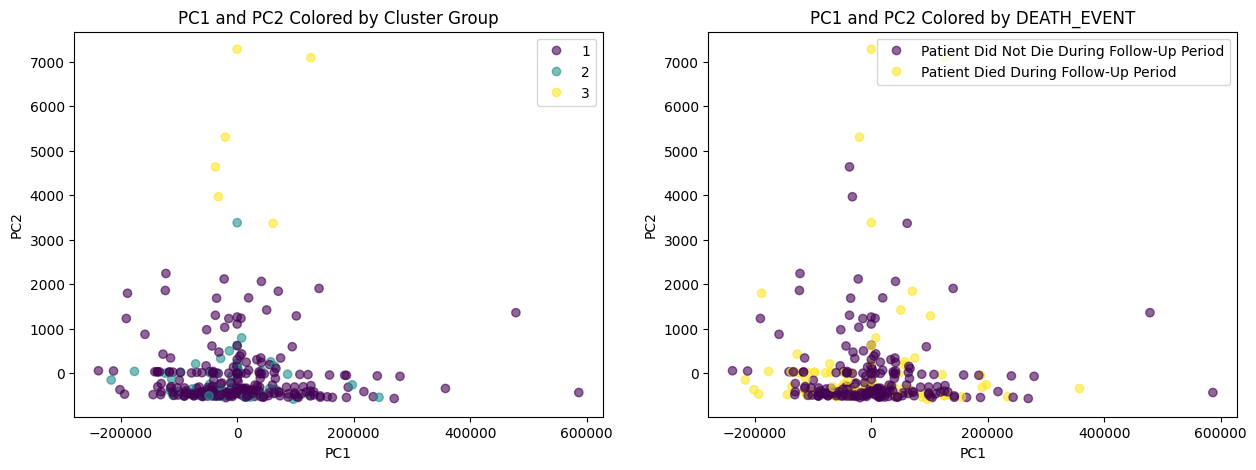

In [131]:
# create model with 3 clusters based on the conclusions drawn from silhouette coefficient analysis
aggModel = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
aggModel.fit_predict(pcaTransformedDataset)

# obtain labels for clusters
aggPreds  = aggModel.labels_

fig, axes = plt.subplots(1,2, figsize =(15,5) )

#left plot
s1 = axes[0].scatter(numerical_transformed[:,0], numerical_transformed[:,1], c=aggPreds, alpha=.6)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("PC1 and PC2 Colored by Cluster Group")

#right plot
s2 = axes[1].scatter(numerical_transformed[:,0], numerical_transformed[:,1], c=heart['DEATH_EVENT'], alpha=.6)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("PC1 and PC2 Colored by DEATH_EVENT")

#legends
deathLabel = ['Patient Did Not Die During Follow-Up Period', 'Patient Died During Follow-Up Period']
clusterLabel = [i for i in range(1,13)]
axes[0].legend(handles=s1.legend_elements()[0], labels=clusterLabel, loc='upper right')
axes[1].legend(handles=s2.legend_elements()[0], labels=deathLabel, loc='upper right')


*Probably the most noticeable difference is that the data points in the k-means scatterplot which were classified into ten clusters are now in only three. One thing to note is that the higher values in the plot above 3000 on the PC2 scale are largely in a single cluster with the hierarchical model, but they are placed into three different clusters in the k-means model. Additionally, the lower values below ~2500 are split into two different clusters in the hierarchical model in a way that follows a very different pattern than the k-means model; rather than being divided vertically in some way, the values in clusters 1 and 2 overlap a lot, whereas there are very clear vertical divides between clusters in the k-means model.*

*When looking at the hierarchical clustering placed next to the graph of PC1 and PC2 colored by death event, it is interesting to notice that cluster 1 seems to encompass much of the data points associated with patients who did not die during the follow-up period, and cluster 2 appears to encompass many of the same datapoints as are associated with patients who did die during the follow-up period. The main exception to this is a few of the higher data points above 3000 on the PC2 scale, which are mostly contained in cluster 3, although both patients who did and did not die during the follow-up period are a part of this third cluster.*